## Fitting method

## Control Variables : <font color = 'sky blue'> $n_e,n_+,n_-,T_e, T_+,T_-, m_+,m_-$ </font>
<font size="2">
    [1] <a href="https://sci-hub.st/https://aip.scitation.org/doi/10.1063/1.4802252"> [2013] Langmuir probe analysis of highly electronegative plasmas</a> <br>
    [2] <a href="https://sci-hub.st/https://doi.org/10.1063/1.4903328"> [2014] Langmuir probe analysis in electronegative plasmas</a> <br><br>
    
Number of control variables can be reduced by set $m_+,m_-$ and $n_+ =n_e+n_-$ <br>
Ion composition setup : $SF_5^+,SF_5^-$ and m=127AMU<br>
Fitting error within 5%

In [1]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import ldf
from scipy.special import erfc
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

## Model Setup

In [30]:
#######################
## Physical Constant ##
#######################
e = 1.6e-19 # electron charge [C]
epsilon_0 = 8.854e-12 # permittivity of vacuum [F/m]
kB = 1.38e-23 #Bolzmann const [kg m2/s2/K]
Mp = 2*1.67e-27 # mass of positive ion [kg] O2+
Mn = 2*1.67e-27 # mass of negative ion [kg] O2-
Me = 9.11e-31 # mass of electron [kg]
hr = 0.6 # h-factor
rp = 0.1e-3/2 # probe radius [m]
lp = 3.5e-3 # probe length [m]
Ap = 2*np.pi*lp*rp + np.pi*rp**2 # probe surface area[m2]


## 계산될 Parameter

In [31]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
    
def solve_as(Te, Tm, a_0):
    def eqn21(a_s):
        return a_0 - a_s*np.exp(-1/2*(1+a_s)/(1+Te/Tm*a_s)*(1-Te/Tm))
    a_s = max(fsolve(eqn21,np.logspace(-4,2,7)))
    return a_s

def cylindrical_sheath(uB, J, V_probe):
    R = 20*rp
    r_list = np.linspace(R, rp, 20000)
    def fun(y, r):
        return [R*J/(r*epsilon_0*y[1]) - y[0]/r, e*y[0]/(Mp*y[1])]   # y는 E, u 로 이루어져있음

    sol = odeint(fun, y0=[0, uB], t=r_list)  # Sheath edge로 추정되는 부분에서 적분 시작
    u = sol[:, 1]
    
    r_sh = r_list[find_nearest(u, np.sqrt(2*e*V_probe/(Mp)))]
    return r_sh

def Seff(V, n_e, n_m, Te, Tm, Vp):
    n_p = n_e + n_m
    a_s = solve_as(Te, Tm, n_m/n_e)
    uBp = np.sqrt(e*Te/Mp)*np.sqrt((1+a_s)/(1+Te/Tm*a_s))
    J = hr*n_p*e*uBp
    r_sh = cylindrical_sheath(uBp, J, abs(V-Vp))
    #r_sh = np.sqrt(4/9*epsilon_0*np.sqrt(2*e/Me)*(abs(V-Vp))**1.5/J)
    return 2*np.pi*r_sh*lp + 2*np.pi*r_sh**2
    #return Ap

#### 위 두개는 iterative class에서 상속받아 쓸거임

def I_p(V, n_e, n_m, Te, Tp, Tm, Vp):
    n_p = n_e + n_m
    a_s = solve_as(Te, Tm, n_m/n_e)
    uBp = np.sqrt(e*Te/Mp)*np.sqrt((1+a_s)/(1+Te/Tm*a_s))

    if Vp > V:
        I_Vp = hr*n_p*e*uBp*Seff(Vp, n_e, n_m, Te, Tm, Vp)
        I = 2*I_Vp - hr*n_p*e*uBp*Seff(V, n_e, n_m, Te, Tm, Vp)
    else:
        I_Vp = hr*n_p*e*uBp*Seff(V, n_e, n_m, Te, Tm, Vp)
        I = I_Vp*np.exp(-(V-Vp)/Tp)
    return I
    
def I_e(V, n_e, Te, Vp):
    ve = np.sqrt(8*e*Te/np.pi/Me)
    
    if Vp > V:
        I = e*Ap*n_e*ve/4*np.exp(-(Vp - V)/Te)
    else:
        I = e*Ap*n_e*ve/2*(2*np.sqrt((V-Vp)/Te/np.pi)+1/2*np.exp((V-Vp)/Te)*erfc((V-Vp)/Te))
    return I
    
def I_n(V, n_e, n_m, Te, Tm, Vp):
    uBn = np.sqrt(e*Tm/Mn)

    if Vp > V:
        I_Vp = hr*n_m*e*uBn*Seff(V, n_e, n_m, Te, Tm, Vp) # Seff(V) function 만들기
        I = I_Vp*np.exp(-(Vp - V)/Tm)
        #print('I: {:.4e}'.format(I))
    else:
        I_Vp = hr*n_m*e*uBn*Seff(Vp, n_e, n_m, Te, Tm, Vp)
        I = 2*I_Vp - hr*n_m*e*uBn*Seff(V, n_e, n_m, Te, Tm, Vp)
        #print('I: {:.4e}'.format(I))
    return I

def total_current(V_input, ne, nm, Te, Tp, Tm):
    I_list = []
    for V in V_input:
        I_list.append(-I_p(V, ne, nm, Te, Tp, Tm, Vp) + I_e(V, ne, Te, Vp) + I_n(V, ne, nm, Te, Tm, Vp))
    return np.array(I_list)

In [32]:
data_iter, data_fit = [], []

workDir = './H2_plasma'
x_type = 'Distance'
parser = ldf.parser(workDir)
ldf_list = parser.ldf_paths()

for file in ldf_list:

    # Check file name
    print(file)

    # Parsing IV curve from ldf file
    IV, imported_eedf, result = parser.pull_attr(file, need_return = True, file_save = False, time_specify = True)

./H2_plasma\8 mTorr R 5 900 W 0 W 12 G 0 mm 1000 us 50% Plasma.ldf


### Test for initial condition (margin applied)

In [49]:
Vp = np.float64(result['Vp'])
margin = 6
ne = 1e16
nm = 2e16
Te = 4
Tp = 0.1
Tm = 0.1

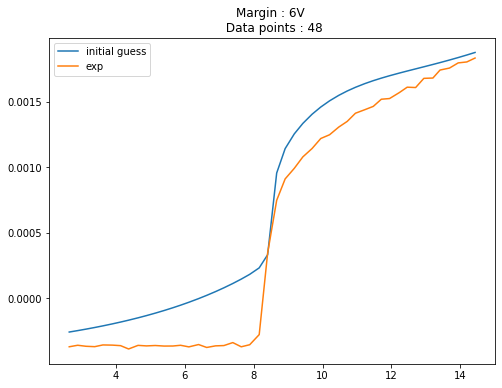

In [50]:
V_list = np.array(IV['V'])
I_list = np.array(IV['I'])

I_list = I_list[V_list < (Vp + margin)]
V_list = V_list[V_list < (Vp + margin)]
I_list = I_list[V_list > (Vp - margin)]
V_list = V_list[V_list > (Vp - margin)]

plt.figure(figsize=(8,6))
plt.plot(V_list, total_current(V_list, ne, nm, Te, Tp, Tm))
plt.plot(V_list, I_list)
plt.legend(['initial guess', 'exp'])
plt.title('Margin : {}V \n Data points : {}'.format(margin, len(V_list)))
plt.show()

In [51]:
#popt, pcov = curve_fit(total_current, V_list, I_list, p0=(1.5e13, 1e15, 2, 0.2, 0.2, 6), bounds=([-np.inf, -np.inf, 0, 0, 0, -100], [np.inf, np.inf, 10, 0.5, 0.5, 100]), method='trf')
#popt, pcov = curve_fit(total_current, V_list, I_list, p0=(1.16e15, 5.56e15, 1.28, 0.2, 0.2)) # ne, nm, Te, Tp, Tm
popt, pcov = curve_fit(total_current, V_list, I_list, p0=(ne, nm, Te, Tp, Tm), bounds=([1e13, 1e13, 0, 0.02, 0.02], [ne*100, nm*100, 5, 0.3, 0.3]), method='trf') # ne, nm, Te, Tp, Tm

c:\Users\GUNU\anaconda3\envs\tf24\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\GUNU\anaconda3\envs\tf24\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [52]:
ne1, nm1, Te1, Tp1, Tm1 = popt
print("Initial Guess  : {:.2e} {:.2e} {:.2e} {:.2e} {:.2e} ".format(ne, nm, Te, Tp, Tm))
print("Fitting Result : {:.2e} {:.2e} {:.2e} {:.2e} {:.2e} ".format(ne1, nm1, Te1, Tp1, Tm1))
I_fitting_list = total_current(V_list, ne1, nm1, Te1, Tp1, Tm1)
mse = (np.square(I_fitting_list - I_list)).mean(axis=0)

Initial Guess  : 1.00e+16 2.00e+16 4.00e+00 1.00e-01 1.00e-01 
Fitting Result : 9.88e+15 3.96e+16 1.08e+00 1.34e-01 9.79e-02 


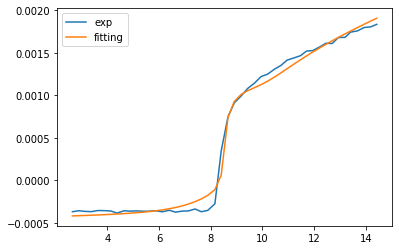

In [54]:
plt.plot(V_list, I_list)
plt.plot(V_list, I_fitting_list)
plt.legend(['exp', 'fitting'])
#plt.text(V_list[0],0, 'Average Error : {:.9f}%'.format(mse), fontsize=10, color='red')
plt.show()

In [69]:
np.diag(pcov)

array([4.94443780e-29, 5.16021926e-29, 2.51421333e-05, 4.01476288e-03,
       2.27930130e-02])